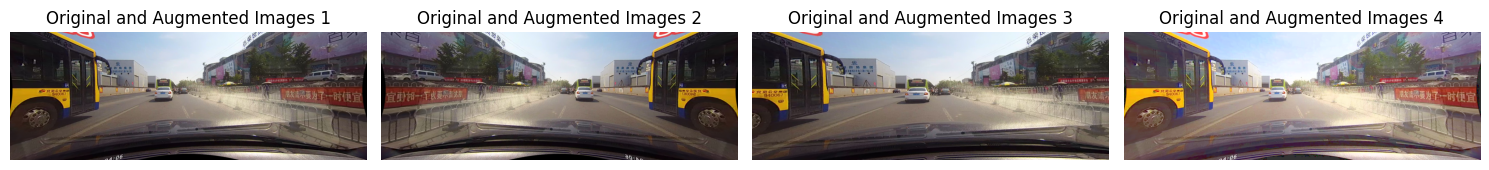

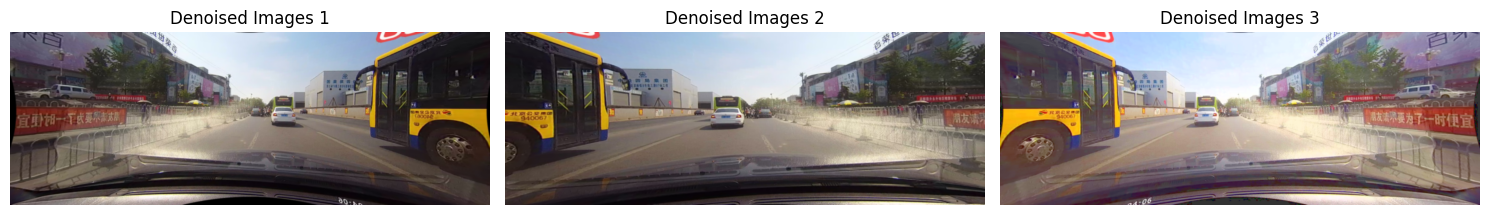

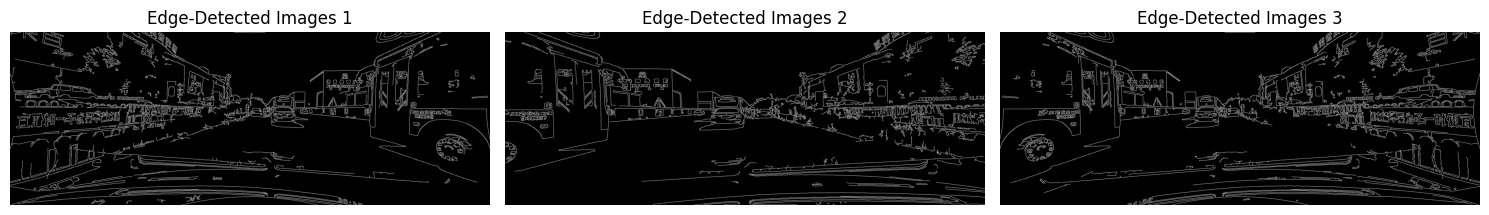

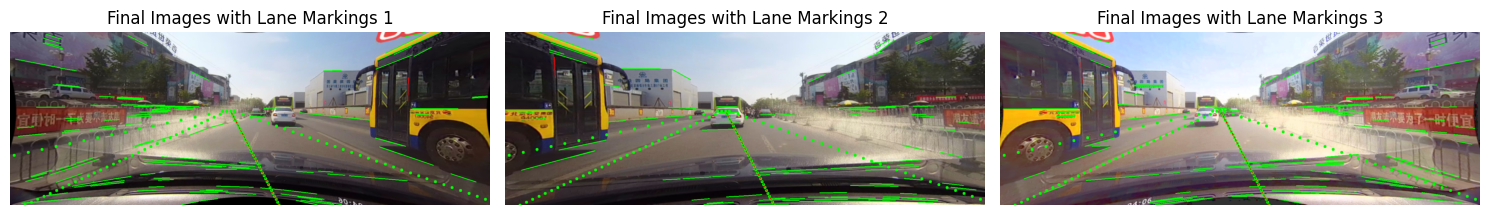

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths to CuLane dataset
image_dir = 'E:/CODE/PrecisionLane/Dataset/driver_37_30frame/05181432_0203.MP4'
label_dir = 'E:/CODE/PrecisionLane/Dataset/driver_37_30frame/05181432_0203.MP4'

image_filename = '03840.jpg'

# Creating a directory to save the output images
output_dir = 'output_images'
os.makedirs(output_dir, exist_ok=True)

# Loading the image
image_path = os.path.join(image_dir, image_filename)
image = cv2.imread(image_path)


# Function to normalize the image (scale pixel values to range [0, 1])
def normalize_image(img):
    return img / 255.0

# Function to perform various augmentations on the image
def augment_images(img):
    # Normalizing the image first
    normalized_img = normalize_image(img)
    
    # To Get the dimensions of the image
    height, width = img.shape[:2]
    
    # Flipping the image horizontally
    flipped = cv2.flip(normalized_img, 1)

    # Randomly cropping the image
    x_start = np.random.randint(0, width // 4)
    y_start = np.random.randint(0, height // 4)
    x_end = np.random.randint(3 * width // 4, width)
    y_end = np.random.randint(3 * height // 4, height)
    cropped = normalized_img[y_start:y_end, x_start:x_end]
    cropped = cv2.resize(cropped, (width, height))

    # Adjusting brightness to create a color-augmented version
    hsv = cv2.cvtColor((normalized_img * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)  # Convert back to uint8 for HSV conversion
    hsv[:, :, 2] = cv2.add(hsv[:, :, 2], 50)
    color_adjusted = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Revert back to [0, 255] range for display and saving
    flipped = np.clip(flipped * 255, 0, 255).astype(np.uint8)
    cropped = np.clip(cropped * 255, 0, 255).astype(np.uint8)
    color_adjusted = np.clip(color_adjusted * 255, 0, 255).astype(np.uint8)

    return flipped, cropped, color_adjusted

# Applying augmentations
flipped_img, cropped_img, color_adjusted_img = augment_images(image)

# Saving augmented images
cv2.imwrite(f"{output_dir}/flipped_image.jpg", flipped_img)
cv2.imwrite(f"{output_dir}/cropped_image.jpg", cropped_img)
cv2.imwrite(f"{output_dir}/color_adjusted_image.jpg", color_adjusted_img)


# Function to apply Gaussian blur for denoising
def denoise_image(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Denoising augmented images
denoised_images = [denoise_image(img) for img in [flipped_img, cropped_img, color_adjusted_img]]

# Saving denoised images
for i, denoised_img in enumerate(denoised_images):
    cv2.imwrite(f"{output_dir}/denoised_image_{i+1}.jpg", denoised_img)

# Function to detect edges using Canny edge detection
def detect_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

# Detecting edges in denoised images
edge_images = [detect_edges(img) for img in denoised_images]

# Saving edge-detected images
for i, edge_img in enumerate(edge_images):
    cv2.imwrite(f"{output_dir}/edge_image_{i+1}.jpg", edge_img)

# Function to store lane points into a label file
def store_lane_points(image, label_filename):
    # Example: Detect lane points using Hough Transform
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=5)
    
    # Store the detected lane points into the label file
    lane_points = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            lane_points.append((x1, y1))
            lane_points.append((x2, y2))
    
    # Write to label file
    label_path = os.path.join(label_dir, label_filename)
    with open(label_path, 'w') as f:
        for point in lane_points:
            f.write(f"{point[0]} {point[1]}\n")

    return lane_points

# Store the lane points into a label file
label_filename = image_filename.replace('.jpg', '.lines.txt')
lane_points = store_lane_points(image, label_filename)

# Function to load lane points from a label file
def load_lane_points(label_filename):
    lane_points = []
    label_path = os.path.join(label_dir, label_filename)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            points = line.strip().split()
            x, y = float(points[0]), float(points[1])
            lane_points.append((x, y))
    
    return lane_points

# Load the lane points from the label file
lane_points_from_file = load_lane_points(label_filename)

# Function to overlay detected lane markings onto the original image
def overlay_lanes(original_img, edges, lane_points):
    lane_img = original_img.copy()
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=5)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for all lane markings

            # Highlighting vertical lanes (if x-coordinates are close)
            if abs(x1 - x2) < 10:  # Vertical threshold
                cv2.line(lane_img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red for vertical segments

    # Adding lane points to the image (regular and vertical)
    for lane in lane_points:
        for i, point in enumerate(lane):
            x, y = int(point[0]), int(point[1])
            cv2.circle(lane_img, (x, y), 5, (0, 255, 0), -1)  # Regular lane points

            # Highlight vertical lane segments
            if i < len(lane) - 1:
                x_next, y_next = int(lane[i + 1][0]), int(lane[i + 1][1])
                if abs(x - x_next) < 10:  # Vertical threshold
                    cv2.line(lane_img, (x, y), (x_next, y_next), (0, 0, 255), 2)  # Red for vertical lines

    return lane_img

# Overlaying lane markings onto the original images
final_images_with_lanes = [overlay_lanes(denoised_img, edges, lane_points) for denoised_img, edges in zip(denoised_images, edge_images)]

# Saving final images with lane markings
for i, final_img in enumerate(final_images_with_lanes):
    cv2.imwrite(f"{output_dir}/final_image_with_lanes_{i+1}.jpg", final_img)

# Displaying all images
def plot_images(title, images, rows, cols):
    plt.figure(figsize=(15, 8))
    for i, img in enumerate(images, 1):
        plt.subplot(rows, cols, i)
        if len(img.shape) == 2:  # Grayscale image
            plt.imshow(img, cmap='gray')
        else:  # Color image
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{title} {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Original and augmented images
plot_images("Original and Augmented Images", [image, flipped_img, cropped_img, color_adjusted_img], 1, 4)

# Denoised images
plot_images("Denoised Images", denoised_images, 1, 3)

# Edge-detected images
plot_images("Edge-Detected Images", edge_images, 1, 3)

# Final images with lanes
plot_images("Final Images with Lane Markings", final_images_with_lanes, 1, 3)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.3):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=dropout)  # Dropout layer for regularization

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout after the first convolution
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Apply dropout after the second convolution
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, feature_channels, dropout=0.3):
        super(Encoder, self).__init__()
        self.conv = ConvBlock(in_channels, feature_channels, dropout)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        features = self.conv(x)
        pooled = self.pool(features)
        return features, pooled


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.3):
        super(Decoder, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, dropout)

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        # Ensure size compatibility during concatenation
        diffY = skip_connection.size()[2] - x.size()[2]
        diffX = skip_connection.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat((x, skip_connection), dim=1)
        x = self.conv(x)
        return x


class PrecisionLane(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, dropout=0.3):
        super(PrecisionLane, self).__init__()
        # Encoder Path
        self.enc1 = Encoder(in_channels, 64, dropout)
        self.enc2 = Encoder(64, 128, dropout)
        self.enc3 = Encoder(128, 256, dropout)
        self.enc4 = Encoder(256, 512, dropout)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024, dropout)

        # Decoder Path
        self.dec4 = Decoder(1024, 512, dropout)
        self.dec3 = Decoder(512, 256, dropout)
        self.dec2 = Decoder(256, 128, dropout)
        self.dec1 = Decoder(128, 64, dropout)

        # Output Layer
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder Path
        enc1_features, enc1_pool = self.enc1(x)
        enc2_features, enc2_pool = self.enc2(enc1_pool)
        enc3_features, enc3_pool = self.enc3(enc2_pool)
        enc4_features, enc4_pool = self.enc4(enc3_pool)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)

        # Decoder Path
        dec4 = self.dec4(bottleneck, enc4_features)
        dec3 = self.dec3(dec4, enc3_features)
        dec2 = self.dec2(dec3, enc2_features)
        dec1 = self.dec1(dec2, enc1_features)

        # Output Layer
        output = self.output_layer(dec1)
        return output


# Example Usage
if __name__ == "__main__":
    # Initialize the model
    model = PrecisionLane(in_channels=3, out_channels=1, dropout=0.3)

    # Create a dummy input tensor (batch_size=1, channels=3, height=590, width=1640)
    dummy_input = torch.randn(1, 3, 590, 1640)

    # Perform a forward pass
    output = model(dummy_input)

    print(f"Input Shape: {dummy_input.shape}")
    print(f"Output Shape: {output.shape}")

Input Shape: torch.Size([1, 3, 590, 1640])
Output Shape: torch.Size([1, 1, 590, 1640])


In [4]:
from torchsummary import summary
print("PrecisionLane Model Summary:")
summary(model, input_size=(3, 590, 1640))

PrecisionLane Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 590, 1640]           1,792
       BatchNorm2d-2        [-1, 64, 590, 1640]             128
         Dropout2d-3        [-1, 64, 590, 1640]               0
            Conv2d-4        [-1, 64, 590, 1640]          36,928
       BatchNorm2d-5        [-1, 64, 590, 1640]             128
         Dropout2d-6        [-1, 64, 590, 1640]               0
         ConvBlock-7        [-1, 64, 590, 1640]               0
         MaxPool2d-8         [-1, 64, 295, 820]               0
           Encoder-9  [[-1, 64, 590, 1640], [-1, 64, 295, 820]]               0
           Conv2d-10        [-1, 128, 295, 820]          73,856
      BatchNorm2d-11        [-1, 128, 295, 820]             256
        Dropout2d-12        [-1, 128, 295, 820]               0
           Conv2d-13        [-1, 128, 295, 820]         14

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])
